## S-Mobile: Predicting Customer Churn
* Team-lead GitLab id:
* Group name:
* Team member names:

## Setup

Please complete this Jupyter notebook by answering the questions in `s-mobile.pdf` on Canvas (week9/). Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML from the Jupyter Notebook file without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the fourth group assignment for MGTA 455 and you will be using git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". git will not decide for you who's change to accept so the team-lead will have to determine which edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import os
import urllib.request
import zipfile
from tempfile import NamedTemporaryFile as tmpfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_pickle("data/s_mobile.pkl")
s_mobile["churn_yes"] = rsm.ifelse(s_mobile["churn"] == "yes", 1, 0)
#s_mobile.head()

In [3]:
##add weights
s_mobile["cweight"] = rsm.ifelse(s_mobile.churn == "yes", 2, 98)

If you want access to the full 1M row dataset, use the code below to download and use the data. Please do **not** include the 1M row dataset in your repo!

The downside to using the dataset with 1M rows is, of course, that estimation time will increase substantially. I do NOT recommend you use this dataset to select your final model or for tuning hyper parameters. You can, however, use this larger dataset to re-estimate your chosen model and generate profit estimates for the representative sample.

In [96]:
## uncomment to run
# url = "https://www.dropbox.com/s/xhiexneeok9gyhs/s_mobile_1M.pkl.zip?dl=1"
# file_path, _ = urllib.request.urlretrieve(url)
# zip_file = zipfile.ZipFile(file_path, "r")
# s_mobile_tmp = zip_file.open(zip_file.namelist()[0])
# os.remove(file_path)
# s_mobile = pd.read_pickle(s_mobile_tmp)

In [97]:
# show dataset description
rsm.describe(s_mobile)

## S-mobile

Dataset used to investigate opportunities to decrease customer churn at S-mobile. The sample consists of three parts:

1. A training sample with 27,300 observations and a 50% churn rate ("training == 1")
2. A test sample with 11,700 observations and a 50% churn rate ("training == 0")
3. A representative sample with 30,000 observations and a churn rate of 2%, i.e., the actual monthly churn rate for S-mobile ("is.na(training)" or "representative == 1")

## Variables

* customer: Customer ID
* churn: Did consumer churn in the last 30 days? (yes or no)
* changer: % change in revenue over the most recent 4 month period
* changem: % change in minutes of use over the most recent 4 month period
* revenue: Mean monthly revenue in SGD
* mou: Mean monthly minutes of use
* overage: Mean monthly overage minutes
* roam: Mean number of roaming calls
* conference: Mean number of conference calls
* months: # of months the customer has had service with S-Mobile
* uniqsubs: Number of individuals listed on the customer account
* custcare: Mean number of calls to customer care 
* retcalls: Number of calls by the customer to the retention team
* dropvce: Mean number of dropped voice calls 
* eqpdays: Number of days customer has owned current handset
* refurb: Handset is refurbished (no or yes)
* smartphone: Handset is a smartphone (no or yes)
* creditr: High credit rating as opposed to medium or low (no or yes)
* mcycle: Subscriber owns a motorcycle (no or yes)
* car: Subscriber owns a car (no or yes)
* travel: Subscriber has traveled internationally (no or yes)
* region: Regions delineated by the 5 Community Development Council Districts (e.g., CS is Central Singapore)
* occupation: Categorical variable with 4 occupation levels (professional, student, retired, or other)
* training: 1 for training sample, 0 for test sample, NA for representative sample
* representative: 1 for representative sample, 0 for training and test sample


Use `smf.glm` with `freq_weights` and `cov_type` like in the below example
    
```python
lr = smf.glm(
    formula="churn_yes ~ changer + changem + ...",
    family=Binomial(link=logit()),
    data=pentathlon_nptb.query("training == 1"),
    freq_weights=s_mobile.loc[mobile.training == 1, "cweight"],
).fit(cov_type="HC1")
```

In [98]:
# run python code from another notebook
%run ./sub-notebooks/model1.ipynb

     index     OR   OR%  2.5%  97.5% p.values    
1  changer  1.001  0.1%   1.0  1.002    0.006  **


In [99]:
# importing functions from a module/package
from utils import functions

functions.example()


You just accessed a function from your first python packages!
Change the code in utils/function.py to whatever you need for this assignment
Use 'from utils import functions' to get access to your code
You can add modules to import from by adding additional .py files to the 'utils' directory
Note: If you make changes to the content of this file you will have to restart the notebook kernel to get the updates



In [4]:
## LG data preparetion
df_lr = s_mobile.copy()

train = df_lr[df_lr["training"] == 1]
test = df_lr[df_lr["training"] == 0]
rep = df_lr[df_lr["representative"] == 1]

# 

# Question answers

# 

## 1. Develop a model to predict customer churn

### Logstic regression base

In [5]:
## Logistic Regression model with weights
lr = smf.glm(
    formula ="churn_yes ~ changer + changem + mou + overage + roam + conference + months + uniqsubs + custcare + retcalls + dropvce \
    + eqpdays + refurb + smartphone + highcreditr + mcycle + car + travel + region + occupation",
    family = Binomial(link = logit()),
    data = train,
    freq_weights = train["cweight"],
    ).fit(cov_type="HC1")

print(rsm.or_ci(lr))
print(rsm.model_fit(lr))
print(rsm.vif(lr))

#print(lr.predict(rep).mean())

                         index     OR     OR%   2.5%  97.5% p.values     
1                refurb[T.yes]  1.319   31.9%  1.274  1.366   < .001  ***
2            smartphone[T.yes]  0.914   -8.6%  0.876  0.953   < .001  ***
3           highcreditr[T.yes]  0.483  -51.7%  0.463  0.504   < .001  ***
4                mcycle[T.yes]  0.883  -11.7%  0.848  0.919   < .001  ***
5                   car[T.yes]  0.990   -1.0%  0.939  1.044    0.717     
6                travel[T.yes]  0.781  -21.9%  0.739  0.825   < .001  ***
7                 region[T.NE]  0.644  -35.6%  0.621  0.668   < .001  ***
8                 region[T.NW]  0.660  -34.0%  0.636  0.684   < .001  ***
9                 region[T.SE]  0.651  -34.9%  0.627  0.675   < .001  ***
10                region[T.SW]  0.627  -37.3%  0.604  0.651   < .001  ***
11  occupation[T.professional]  1.415   41.5%  1.372  1.460   < .001  ***
12       occupation[T.student]  1.900   90.0%  1.820  1.983   < .001  ***
13       occupation[T.retired]  0.186 

In [6]:
lr.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,11808.123,0.000,1
refurb,244.282,0.000,1
smartphone,17.700,0.000,1
highcreditr,1124.217,0.000,1
mcycle,36.662,0.000,1
car,0.131,0.717,1
travel,77.553,0.000,1
region,1011.513,0.000,4
occupation,3404.207,0.000,3
changer,24.332,0.000,1


# 

### Logistic Regression with weights without insignificant features

In [7]:
## Logistic Regression with weights without insignificant features
lr = smf.glm(
    formula = "churn_yes ~ changer + changem + mou + overage + roam + conference + months + uniqsubs + retcalls + dropvce \
    + eqpdays + refurb + smartphone + highcreditr + mcycle + travel + region + occupation",
    family = Binomial(link = logit()),
    data = train,
    freq_weights = train["cweight"],
    ).fit(cov_type = "HC1")

print(rsm.or_ci(lr))
print(rsm.model_fit(lr))
print(rsm.vif(lr))

print(lr.predict(rep).mean())

                         index     OR     OR%   2.5%  97.5% p.values     
1                refurb[T.yes]  1.318   31.8%  1.273  1.365   < .001  ***
2            smartphone[T.yes]  0.914   -8.6%  0.876  0.953   < .001  ***
3           highcreditr[T.yes]  0.481  -51.9%  0.461  0.502   < .001  ***
4                mcycle[T.yes]  0.879  -12.1%  0.852  0.907   < .001  ***
5                travel[T.yes]  0.780  -22.0%  0.739  0.825   < .001  ***
6                 region[T.NE]  0.644  -35.6%  0.621  0.668   < .001  ***
7                 region[T.NW]  0.660  -34.0%  0.637  0.685   < .001  ***
8                 region[T.SE]  0.651  -34.9%  0.628  0.675   < .001  ***
9                 region[T.SW]  0.627  -37.3%  0.605  0.651   < .001  ***
10  occupation[T.professional]  1.417   41.7%  1.373  1.461   < .001  ***
11       occupation[T.student]  1.900   90.0%  1.821  1.984   < .001  ***
12       occupation[T.retired]  0.186  -81.4%  0.173  0.201   < .001  ***
13                     changer  1.001 

# 

### Standardizing

In [8]:
Xs = rsm.scale_df(
    df_lr.loc[:, "changer":"occupation"],
    wt = df_lr.cweight,
    train = df_lr.training == 1,
)
Xs["churn_yes"] = df_lr.churn_yes
Xs["training"] = df_lr.training
Xs["representative"] = df_lr.representative
Xs

,changer,changem,revenue,mou,overage,roam,conference,months,uniqsubs,custcare,...,smartphone,highcreditr,mcycle,car,travel,region,occupation,churn_yes,training,representative
0,1.795996,0.648059,0.059201,0.051482,0.583946,-0.090861,-0.126390,-0.534447,-0.299926,-0.285786,...,yes,no,no,no,no,CS,other,1,0.0,0
1,-0.146109,-0.134122,-0.032648,-0.364217,-0.453367,-0.090861,-0.126390,-0.534447,0.275305,-0.285786,...,yes,yes,no,no,no,SE,other,0,0.0,0
2,-0.146109,-0.254458,-0.204864,0.562407,0.252889,-0.090861,0.310452,-0.483883,-0.299926,1.891054,...,yes,no,yes,no,yes,NW,professional,0,NaN,1
3,-0.146109,-0.244430,-0.250789,0.014857,-0.453367,-0.090861,-0.126390,0.931900,-0.299926,-0.285786,...,yes,yes,yes,no,no,NW,retired,0,1.0,0
4,-0.181744,-0.244430,0.495484,1.230822,0.370598,0.675463,-0.126390,0.072318,0.850537,-0.056645,...,yes,no,yes,yes,no,SW,other,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68995,-0.146109,-0.314625,-0.273751,-0.453034,-0.453367,-0.090861,-0.126390,0.021754,-0.299926,-0.285786,...,yes,no,yes,yes,no,SW,other,0,NaN,1
68996,-0.146109,0.788450,-0.308194,-0.426480,-0.453367,-0.090861,-0.126390,-0.028810,0.275305,-0.285786,...,no,no,yes,yes,no,SE,other,0,1.0,0
68997,-0.146109,-0.114066,-0.158940,-0.268991,-0.063455,-0.090861,-0.126390,0.325136,0.275305,-0.285786,...,no,no,no,no,no,CS,student,1,0.0,0
68998,-0.199561,-0.455017,-0.181902,-0.234197,-0.453367,-0.090861,-0.126390,0.021754,-0.299926,-0.285786,...,yes,no,no,no,no,CS,other,1,1.0,0


# 

### Logistic reg without insig features and with numeric vars stded

In [9]:
lr_std = smf.glm(
    formula = "churn_yes ~ changer + changem + mou + overage + roam + conference + months + uniqsubs + retcalls + dropvce \
    + eqpdays + refurb + smartphone + highcreditr + mcycle + travel + region + occupation",
    family = Binomial(link = logit()),
    data = Xs[df_lr.training == 1],
    freq_weights = train["cweight"],
).fit(cov_type = "HC1")

print(rsm.or_ci(lr))
print(rsm.model_fit(lr))
print(rsm.vif(lr))

print(lr_std.predict(Xs[df_lr.representative == 1]).mean())

                         index     OR     OR%   2.5%  97.5% p.values     
1                refurb[T.yes]  1.318   31.8%  1.273  1.365   < .001  ***
2            smartphone[T.yes]  0.914   -8.6%  0.876  0.953   < .001  ***
3           highcreditr[T.yes]  0.481  -51.9%  0.461  0.502   < .001  ***
4                mcycle[T.yes]  0.879  -12.1%  0.852  0.907   < .001  ***
5                travel[T.yes]  0.780  -22.0%  0.739  0.825   < .001  ***
6                 region[T.NE]  0.644  -35.6%  0.621  0.668   < .001  ***
7                 region[T.NW]  0.660  -34.0%  0.637  0.685   < .001  ***
8                 region[T.SE]  0.651  -34.9%  0.628  0.675   < .001  ***
9                 region[T.SW]  0.627  -37.3%  0.605  0.651   < .001  ***
10  occupation[T.professional]  1.417   41.7%  1.373  1.461   < .001  ***
11       occupation[T.student]  1.900   90.0%  1.821  1.984   < .001  ***
12       occupation[T.retired]  0.186  -81.4%  0.173  0.201   < .001  ***
13                     changer  1.001 

# 

### Importance of Logistic reg without insig vars and without std but with weights

In [10]:
imp = (
    rsm.or_ci(lr_std, importance = True, data = Xs[df_lr.training == 1])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)
imp

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance,wmean,wstd,min,max
0,occupation[T.retired],0.186,-81.4%,0.173,0.201,< .001,***,True,5.369,0.137,0.344,0.000,1.000
1,highcreditr[T.yes],0.481,-51.9%,0.461,0.502,< .001,***,True,2.079,0.180,0.384,0.000,1.000
2,occupation[T.student],1.900,90.0%,1.821,1.984,< .001,***,True,1.900,0.055,0.227,0.000,1.000
3,eqpdays,1.832,83.2%,1.776,1.889,< .001,***,False,1.832,0.000,0.500,-1.097,3.305
4,overage,1.764,76.4%,1.712,1.818,< .001,***,False,1.764,0.000,0.500,-0.453,1.629
5,region[T.SW],0.627,-37.3%,0.605,0.651,< .001,***,True,1.594,0.202,0.401,0.000,1.000
6,region[T.NE],0.644,-35.6%,0.621,0.668,< .001,***,True,1.552,0.199,0.399,0.000,1.000
7,region[T.SE],0.651,-34.9%,0.628,0.675,< .001,***,True,1.536,0.199,0.399,0.000,1.000
8,mou,0.656,-34.4%,0.627,0.685,< .001,***,False,1.526,-0.000,0.500,-0.498,6.523
9,region[T.NW],0.660,-34.0%,0.637,0.685,< .001,***,True,1.515,0.199,0.399,0.000,1.000


# 

### Check overfitting

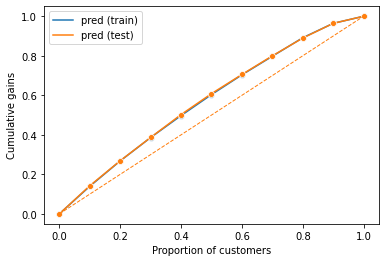

In [11]:
pred_train = pd.DataFrame().assign(actual = train["churn_yes"], pred = lr.predict(Xs[df_lr.training == 1]))
pred_test = pd.DataFrame().assign(actual=test["churn_yes"], pred = lr.predict(Xs[df_lr.training == 0]))


dct = {"train": pred_train, "test": pred_test}
fig = rsm.gains_plot(dct, "actual", 1, "pred").legend(title=None)

# 

## 2. Use the model output from a logistic regression to understand the main drivers of churn and report on the key factors that predict customer churn and their relative importance

# 

### Importance table

In [108]:
#imp.head(3)
imp

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance,wmean,wstd,min,max
0,occupation[T.retired],0.186,-81.4%,0.173,0.201,< .001,***,True,5.369,0.137,0.344,0.000,1.000
1,highcreditr[T.yes],0.481,-51.9%,0.461,0.502,< .001,***,True,2.079,0.180,0.384,0.000,1.000
2,occupation[T.student],1.900,90.0%,1.821,1.984,< .001,***,True,1.900,0.055,0.227,0.000,1.000
3,eqpdays,1.832,83.2%,1.776,1.889,< .001,***,False,1.832,0.000,0.500,-1.097,3.305
4,overage,1.764,76.4%,1.712,1.818,< .001,***,False,1.764,0.000,0.500,-0.453,1.629
5,region[T.SW],0.627,-37.3%,0.605,0.651,< .001,***,True,1.594,0.202,0.401,0.000,1.000
6,region[T.NE],0.644,-35.6%,0.621,0.668,< .001,***,True,1.552,0.199,0.399,0.000,1.000
7,region[T.SE],0.651,-34.9%,0.628,0.675,< .001,***,True,1.536,0.199,0.399,0.000,1.000
8,mou,0.656,-34.4%,0.627,0.685,< .001,***,False,1.526,-0.000,0.500,-0.498,6.523
9,region[T.NW],0.660,-34.0%,0.637,0.685,< .001,***,True,1.515,0.199,0.399,0.000,1.000


In [12]:
imp.head(5)

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance,wmean,wstd,min,max
0,occupation[T.retired],0.186,-81.4%,0.173,0.201,< .001,***,True,5.369,0.137,0.344,0.000,1.000
1,highcreditr[T.yes],0.481,-51.9%,0.461,0.502,< .001,***,True,2.079,0.180,0.384,0.000,1.000
2,occupation[T.student],1.900,90.0%,1.821,1.984,< .001,***,True,1.900,0.055,0.227,0.000,1.000
3,eqpdays,1.832,83.2%,1.776,1.889,< .001,***,False,1.832,0.000,0.500,-1.097,3.305
4,overage,1.764,76.4%,1.712,1.818,< .001,***,False,1.764,0.000,0.500,-0.453,1.629


### We excluded all statistically insignificant predictors, and most final predictors are significant under 0.001 significant level.
### We observed that being retired, having a high credit rating, and being a student conquer the top three places in terms of importance ranking, which suggest that one observation having the attribute of any one of them or contribute significantly to his/her churning prediction.
- Compare to "other" occupations, the odds of churning for being a retiree was 81.5% lower, keeping all other variables in the model constant.
- Compare to not having a high credit rating, the odds of churning for being a high credit rated user was 51.9% lower, keeping all other variables in the model constant.
- Compare to "other" occupations, the odds of churning for being a student was 90.0% higher, keeping all other variables in the model constant.

### On the other hand, eqpdays and overage ranked the 4th and 5th.
- For an one standard deviation increase in number of days customer has owned current handset, the standard deviation of odds of clicking ads increased by 83.2%, keeping all other variables in the model constant.
- For an one standard deviation increase in mean monthly overage minutes, the standard deviation of odds of clicking ads increased by 76.4%, keeping all other variables in the model constant.

# 

## 3. Use insights on churn drivers to develop actions/offers/incentives
- Consider each variable type, e.g., “Equipment characteristic”, “Customer usage”, etc. (see the data table at the end of this case)

# &

## 4. Quantify the impact of these actions/offers/incentives on the probability of churn
- Either (i) predict the effect of a churn driver (similar to what we did for Pentathlon III) or (ii) suggest how you might set up an experiment (RCT) to evaluate the action/incentive/offer in the field
- Generate predictions for the representative sample
- Since you can’t actually execute an RCT, describe how you would set up such an experiment and then make an assumption about the impact on churn that you can use in steps 5 and 6

# 

## CLV calculator

In [13]:
def clv_calculator(data = df_lr, monthly_discount = 0.008, nr_years = 5):
    churn = lr.predict(data[data['representative'] == 1]).mean()
    print('Then mean churn rate on representative set is',churn)
    churn = churn.repeat(12 * nr_years)
    churn[0] = 0 #No churn in the first month
    retention = (1.0 - churn).cumprod()
    revenue = s_mobile[s_mobile['representative'] == 1]['revenue'].mean()
    revenue = revenue.repeat(12 * nr_years)
    expected_revenue = revenue * retention
    discount_month = np.arange(0, nr_years * 12, 1)
    cum_discount = np.power(1 + monthly_discount, discount_month)
    pv_expected_profit = expected_revenue / cum_discount
    clv = np.cumsum(pv_expected_profit)[-1]
    return clv
    
ori_clv = clv_calculator(data = df_lr, monthly_discount = 0.008, nr_years = 5)
ori_clv

Then mean churn rate on representative set is 0.019800147680437304


1670.029791323236

# 

## Customer characteristic

### categorical variable resampleing function

- We believe that instead of replacing merely the occupation level of certain groups of customer, it's more reasonable to swap all features/attributes, as in this way, data points would be as the same representative as they did.
- We implemented this by filtering out target group and randomly replace them back into the rest of the data set (complete row). 
- The modified data set remains the same size as before.
- The ratio of targeted group is enlarged/shrink. 

In [16]:
from random import randint
def sampling(df = s_mobile, feature_name = 'occupation', sampling_name = 'retired', pect_samples = 0.2):
    df = df[df["representative"] == 1]
    rows = df.shape[0]
    n_samples = int(rows * pect_samples)
    sampling_df = df[df[feature_name] == sampling_name]
    unsampling_df = df[df[feature_name] != sampling_name]
    samples = sampling_df.sample(n = n_samples, replace = True).reset_index().drop(["index"], axis = 1)   #bootstrap
    unsamples = unsampling_df.sample(n = rows - n_samples, replace = False).reset_index().drop(["index"], axis = 1)

    return pd.concat([samples, unsamples], axis = 0)

sampling(df = s_mobile, feature_name = 'occupation', sampling_name = 'retired')

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,highcreditr,mcycle,car,travel,region,occupation,training,representative,churn_yes,cweight
0,U38510830,no,0,29,56,741,0,1,0,45,...,no,no,no,no,NW,retired,NaN,1,0,98
1,U45627446,no,63,161,25,107,103,0,1,29,...,no,no,no,no,SW,retired,NaN,1,0,98
2,U39657021,no,-5,-18,32,549,0,1,0,10,...,yes,yes,no,no,NW,retired,NaN,1,0,98
3,U98477803,no,0,162,91,56,0,0,0,14,...,no,no,no,no,SE,retired,NaN,1,0,98
4,U24996375,no,-1,28,21,64,49,0,0,20,...,no,no,no,no,NW,retired,NaN,1,0,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,U49757722,no,-3,46,115,1025,112,0,0,12,...,no,yes,yes,no,CS,other,NaN,1,0,98
23996,U55826928,no,-3,-1,43,632,104,0,0,9,...,no,no,no,no,SW,professional,NaN,1,0,98
23997,U41126684,no,-1,-29,82,174,0,0,0,49,...,no,no,no,no,NE,other,NaN,1,0,98
23998,U71417600,no,120,-49,42,377,77,0,1,12,...,no,no,no,no,NE,professional,NaN,1,0,98


# 

### 'retired'

- In the customer characteristic category, we observed 'retired' level of variable occupation was ranked first in the category and also among all variables for its importence to churn rate.
- Being a retired customer is negatively correlated with churn, specifically ,all else equal, being a retire customer is associate on average with 81.4% less probability of churn than being 'other' occupation level customer.
- Thus, we aim to enlarge the ratio of retired customer in our customer base. This could be implemented by advertising in senior communities, or send promotion emails/text to elder potential customers.

In [17]:
retired_df = sampling(df = s_mobile, feature_name = 'occupation', sampling_name = 'retired', pect_samples = 0.2)
retired_df["occupation"].value_counts(normalize = True)

other           0.587933
retired         0.200000
professional    0.161100
student         0.050967
Name: occupation, dtype: float64

In [18]:
new_clv = clv_calculator(data = retired_df, monthly_discount = 0.008, nr_years = 5)
change_rate = new_clv / ori_clv
print('By inceasing the propotion of retired customers, our new data gains', change_rate, 'times of CLV compare to the original data,', 'from', ori_clv, 'to', new_clv)

Then mean churn rate on representative set is 0.01870117258984271
By inceasing the propotion of retired customers, our new data gains 1.0245319276275502 times of CLV compare to the original data, from 1670.029791323236 to 1710.9988412998302


# 

### 'highcreditr'

- In the customer characteristic category, we observed 'highcreditr' level of variable occupation was ranked the second among all other variables/categorical levels.
- Being a high credit rating customer is also negatively correlated with churn, specifically ,all else equal, being a high credit rating customer is associate on average with 51.9% less probability of churn than being 'other' occupation level customer.
- Thus, we aim to enlarge the ratio of high credit rating customer in our customer base. This could be implemented by partner with financial institutions such as banks and acquire customer lists who have high credit raings. Then, we may promote the s_mobile to them.

In [19]:
highcreditr_df = sampling(df = s_mobile, feature_name = 'highcreditr', sampling_name = 'yes', pect_samples = 0.25)
change_rate = new_clv / ori_clv
highcreditr_df["highcreditr"].value_counts(normalize = True)

no     0.75
yes    0.25
Name: highcreditr, dtype: float64

In [20]:
new_clv = clv_calculator(data = highcreditr_df, monthly_discount = 0.008, nr_years = 5)
change_rate = new_clv / ori_clv
print('By inceasing the propotion of high credit customers our new data gains', change_rate, 'times of CLV compare to the original data', 'from', ori_clv, 'to', new_clv )

Then mean churn rate on representative set is 0.018978244755704046
By inceasing the propotion of high credit customers our new data gains 1.0182616523910557 times of CLV compare to the original data from 1670.029791323236 to 1700.5272948550883


# 

## Usage trend

### "changem"

- between the two usage trend variables, there's only one variable, we can work on to improve the final churn rate. "changer" as a subjective observation is what we have no control of, however, we can work on "changem" to lower the churn rate.
- We aim to higher the "changem" in order to lower the churn as they are negatively correlated. All else equal, one standard deviation increase of "changem" is associate on average in the current model to 13.6% lower churn rate.
- Some potential implementation could be: 1. Improve service quality, so that customers wouldn't having trouble accessing to the mobile service in low signal level areas. 2. give cheaper service fee rate when customers use more often (thus more minutes used)

In [116]:
changem_df = s_mobile.copy()
increase_rate = 0.3
changem_df['changem'] = [i * (1 + increase_rate) if i > 0 else i / (1 + increase_rate) for i in s_mobile['changem']]

In [117]:
ori_clv = clv_calculator(data = df_lr, monthly_discount = 0.008, nr_years = 5)
new_clv = clv_calculator(data = changem_df, monthly_discount = 0.008, nr_years = 5)

change_rate = new_clv / ori_clv
print('By applying a',increase_rate * 10, 'percent increase (assumed) in variable changem, our new data gains', change_rate, 'times of CLV compare to the original data,', 'from', ori_clv, 'to', new_clv )

Then mean churn rate on representative set is 0.019800147680437304
Then mean churn rate on representative set is 0.01958038461510778
By applying a 3.0 percent increase (assumed) in variable changem, our new data gains 1.00483385401248 times of CLV compare to the original data, from 1670.029791323236 to 1678.1024715309848


# 

## Customer Usage 

###  'uniqsubs'

- In the Customer Usage category, we observed 'uniqsubs' was ranked the first among all other customer usage variables.
- From the importance table, we learned that 'uniqsubs' is positively correlated with churn rate. Specifically, all else equal, one unit increase in 'uniqsubs' is associate on average with 6.7% of increase in churn rate, thus we'll aim to lower the 'uniqsubs' to get a lower churn rate.
- This could be implemented by restricting number of individuals registering to one account.

In [118]:
uniqsubs_df = s_mobile.copy()
drop_numer = 1
uniqsubs_df['uniqsubs'] = [i - drop_numer if i >= (drop_numer + 1) else i for i in s_mobile['uniqsubs']]

In [119]:
ori_clv = clv_calculator(data = df_lr, monthly_discount = 0.008, nr_years = 5)
new_clv = clv_calculator(data = uniqsubs_df, monthly_discount = 0.008, nr_years = 5)

change_rate = new_clv / ori_clv
print('By dropping',drop_numer, 'person(s) per account (assumed) in variable changem, our new data gains', change_rate, 'times of CLV compare to the original data,', 'from', ori_clv, 'to', new_clv)

Then mean churn rate on representative set is 0.019800147680437304
Then mean churn rate on representative set is 0.019531918583159284
By dropping 1 person(s) per account (assumed) in variable changem, our new data gains 1.0059046802058889 times of CLV compare to the original data, from 1670.029791323236 to 1679.890783175307


# 

### 'overage'

- We found that overage has 76.4% odd ratio  which means for an one standard deviation increase in mean monthly overage minutes, the odds of churn increased by 76.4%, keeping all other variables in the model constant. 
- Thus, we came up with an idea that S-mobile can provide additional free 25 minutes for those whose usage is between 51 - 100 minutes,and 50 minutes for those whose usage is over 100 minutes.

In [21]:
overage_df = s_mobile.copy()
overage_df['overage'] = overage_df["overage"].apply(lambda x: x - 50 if x > 100 else (x - 25 if (x > 50) and (x <= 100) else x))

In [22]:
overage_df_std = rsm.scale_df(
    overage_df.loc[:, "changer":"occupation"],
    wt = overage_df.cweight,
    train = overage_df.training == 1,
)
overage_df_std["churn_yes"] = s_mobile.churn_yes
overage_df_std["training"] = s_mobile.training
overage_df_std["representative"] = s_mobile.representative
#overage_df_std

In [23]:
new_clv = clv_calculator(data = overage_df, monthly_discount = 0.008, nr_years = 5)

change_rate = new_clv / ori_clv
print('By decreasing overage, our new data gains', change_rate, 'times of CLV compare to the original data,', 'from', ori_clv, 'to', new_clv )

Then mean churn rate on representative set is 0.01806744398164429
By decreasing overage, our new data gains 1.0390947445726653 times of CLV compare to the original data, from 1670.029791323236 to 1735.3191794437594


# 

### 'mou' 

- We found that overage has -34.45% odd ratio which means for an one standard deviation increase in mean monthly overage minutes, the odds of churn decrease by 34.45%, keeping all other variables in the model constant. 
- A potential implementation could be that we can provide additional free 100 minutes for whom satisfies 800 minutes of usage,and 30 minutes for whom satisfies only 300 minutes of usage.
- We assume they'll use all of the free minutes.

In [26]:
mou_df = s_mobile.copy()

mou_df['mou'] = mou_df["mou"].apply(lambda x: x + 100 if x >= 800 else (x + 30 if (x >= 300) and (x < 800) else x))

new_clv = clv_calculator(data = mou_df, monthly_discount = 0.008, nr_years = 5)
change_rate = new_clv / ori_clv
print('By inceasing monthly minutes of use, our new data gains', change_rate, 'times of CLV compare to the original data', 'from', ori_clv, 'to', new_clv )

Then mean churn rate on representative set is 0.019579549200680203
By inceasing monthly minutes of use, our new data gains 1.0048522972922818 times of CLV compare to the original data from 1670.029791323236 to 1678.1332723577034


# 

## 5. Decide which actions/offers/incentives to target to which customers
- For each action/offer/incentive specify the criteria used to select customers. Will you apply the action/offer/incentive to all customers, or a subset? Motivate your approach

### Final strategy
- By ranking the improvements, we observed that the best strategies would be 1.enlarging the retired customer ratio; 2. decrease overage usage; 3.enlarging the high credit rating customers ratio.
- These could be implemented by 1. advertising in senior communities, or send promotion emails/text to elder potential customers; 2. provide additional free 25 minutes for those whose usage is between 51 - 100 minutes,and 50 minutes for those whose usage is over 100 minutes; 3.partner with financial institutions such as banks and acquire customer lists who have high credit ratings. Then, we may promote the s_mobile to they. 



## 6. Evaluate the economics: For each action/offer/incentive evaluate the profitability implications using a 5-year (60 month) time window

- By decreasing overage, providing additional free 25 minutes for those whose usage is between 51 - 100 minutes,and 50 minutes for those whose usage is over 100 minutes, our new data gains 1.039312934087106 times of CLV compare to the original data, from 1670.029791323236 to 1735.6835624330297


- By increasing the proportion of high credit customers, assumably reweighing to 25% of the whole customer base, our new data gains 1.0174672332495394 times of CLV compare to the original data, from 1670.029791323236 to 1700.5272948550883
.

- By inceasing the propotion of retired customers, assumably reweighing to 20% of the whole customer base,  our new data gains 1.0252328291433297 times of CLV compare to the original data, from 1670.029791323236 to 1710.9988412998302.

- By dropping 1 person(s) per account (assumed) in variable changem, our new data gains 1.0059046802058889 times of CLV compare to the original data. from 1670.029791323236 to 1679.890783175307.

- By applying a 3.0 percent increase (assumed) in variable changem, our new data gains 1.00483385401248 times of CLV compare to the original data. from 1670.029791323236 to 1678.1024715309848.

# 

# 